In [1]:
import pandas as pd
import re
import pickle
from textblob import TextBlob
from textstat.textstat import textstat
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation #can get rid of this after pickle works
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
% matplotlib inline

This model uses a final data file, "final_ttpc_data_3831rows.csv" that is all the english books with library counts between 2 and 1500, duplicate rows dropped, and the 8 rows that lack an age dropped. The three columns of relevance to this model are the "y"--extracted_libcount and the two X variables--proper_title and age_in_2017. The input pipeline needs to turn any titles into proper titles and add an age of 0 to all books.

In [2]:
df = pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/full_data/final_ttpc_data_3831rows.csv", usecols=[ "extracted_libcount", "age_in_2017", "proper_title"])

In [3]:
df.head()

,extracted_libcount,age_in_2017,proper_title
0,1488,15.0,Bloody Jack: Being an Account of the Curious A...
1,1445,12.0,Immortal in Death
2,1425,18.0,The Body's Perilous Pleasures: Dangerous Desir...
3,1424,4.0,The (Honest) Truth About Dishonesty: How We Li...
4,1422,1.0,The Berenstain Bears Meet Santa Bear


In [4]:
df.shape

(3831, 3)

### add the title-based features to the 2-1500 set

In [5]:
#add sentiment analysis
def text_blob_sentiment_polarity(value):
    blob = TextBlob(value)
    return blob.sentiment.polarity
def text_blob_sentiment_subjectivity(value):
    blob = TextBlob(value)
    return blob.sentiment.subjectivity

In [6]:
df["sentiment_polarity"] = df["proper_title"].apply(text_blob_sentiment_polarity)

In [7]:
df["sentiment_subjectivity"] = df["proper_title"].apply(text_blob_sentiment_subjectivity)

In [8]:
#add reading level
def reading_level_comp(string):
    try:
        level = textstat.text_standard(string)
        return level
    except:
        return "Unclear"

In [9]:
df["reading_level"] = df["proper_title"].apply(reading_level_comp)

In [10]:
#make reading level into a dummies df
lb_rl = LabelBinarizer()
reading_level_lb = lb_rl.fit_transform(df["reading_level"])

In [11]:
reading_level_dummies = pd.DataFrame(reading_level_lb)

In [12]:
reading_level_dummies.shape

(3831, 49)

In [13]:
#add number of words column
df["number_of_words"] = df["proper_title"].apply(lambda x: len(x.split()))

In [14]:
#add title length
df["title_length"] = df["proper_title"].apply(lambda x: len(x))

In [15]:
# this is commented out because I'm seeing if the pickled model will work now
#add topic modeling
# cv_for_lda = CountVectorizer(min_df=5, max_df=.75, ngram_range=(1,3), stop_words="english")

# words = cv_for_lda.fit_transform(df["proper_title"])

In [16]:
#ditto re: commented out to see if pickled model works
# lda_8 = LatentDirichletAllocation(n_topics=8, max_iter=15,
#                                 topic_word_prior=2,
#                                 learning_offset=50., random_state=3)

# lda_8.fit(words)

In [17]:
#pull in pickled lda model
lda_8 = pickle.load(open('ttpc_lda.pkl', 'rb'))
cv_for_lda = pickle.load(open('cv_for_lda.pkl', 'rb'))

In [18]:
words = cv_for_lda.fit_transform(df["proper_title"])

In [19]:
#ORIGINAL VERSION OF LDA TRANSFORM

# transformed_data_8= lda_8.transform(words)
# transformed_data_8 = pd.DataFrame(transformed_data_8, columns=['Topic %s' % x for x in range(8)])

In [20]:
#version with pickles
transformed_data_8= lda_8.transform(words)
transformed_data_8 = pd.DataFrame(transformed_data_8, columns=['Topic %s' % x for x in range(8)])

In [21]:
def top_topic_number_extractor(dataframe):
    top_topic_list = []
    for i in dataframe.index:
        ordered_row = dataframe.iloc[i,:].sort_values(ascending=False)
        top_topic_name = ordered_row.index[0]
        count_pattern = re.compile("\d+")
        top_topic_number = count_pattern.search(top_topic_name).group()
        top_topic_list.append(int(top_topic_number))
    return top_topic_list

In [22]:
df["top_topic_number_lda8"] = top_topic_number_extractor(transformed_data_8)

In [23]:
#make dummy variable columns for top topic number
lb = LabelBinarizer()
topic_lb = lb.fit_transform(df["top_topic_number_lda8"])

In [24]:
#make df with categoricalized top topics
top_topics_df = pd.DataFrame(topic_lb)
top_topics_df.head()

,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0


In [25]:
#pickling this now
#tfidf vectorize the words:
#all lowercase consistently worked worse, so keeping capitalization here
#giving this a test now with stopwords--still unclear if they should stay
# tfidf = TfidfVectorizer(min_df=5, max_df=.95, lowercase=False, stop_words="english", ngram_range=(1,3))
# tfidf_title = tfidf.fit_transform(df["proper_title"])

In [26]:
#pull in pickled tfidf
tfidf = pickle.load(open('tfidf.pkl', 'rb'))
tfidf_title = tfidf.fit_transform(df["proper_title"])

In [27]:
# this line can go if all works--was checking the length of the vocabulary
len(tfidf.vocabulary_)

923

In [28]:
#make it into a df to join onto beginning data:
tfidf_title_df = pd.DataFrame(tfidf_title.todense(), 
                  columns=tfidf.get_feature_names())

In [29]:
tfidf_title_df.shape

(3831, 923)

In [30]:
df.head()

,extracted_libcount,age_in_2017,proper_title,sentiment_polarity,sentiment_subjectivity,reading_level,number_of_words,title_length,top_topic_number_lda8
0,1488,15.0,Bloody Jack: Being an Account of the Curious A...,-0.450000,0.950000,11th and 12th grade,15,89,6
1,1445,12.0,Immortal in Death,0.000000,0.000000,3th and 4th grade,3,17,0
2,1425,18.0,The Body's Perilous Pleasures: Dangerous Desir...,-0.216667,0.533333,36th and 37th grade,9,73,0
3,1424,4.0,The (Honest) Truth About Dishonesty: How We Li...,0.600000,0.900000,24th and 25th grade,11,81,5
4,1422,1.0,The Berenstain Bears Meet Santa Bear,0.000000,0.000000,1th and 2th grade,6,36,3


In [31]:
df.shape

(3831, 9)

### create y and X for modeling

In [32]:
y = df["extracted_libcount"]

In [33]:
#in original model trials this was X2
X = pd.concat([df[["age_in_2017", "sentiment_polarity", "sentiment_subjectivity", "number_of_words", "title_length"]], top_topics_df, tfidf_title_df, reading_level_dummies], axis=1)

In [34]:
# X.shape

In [35]:
X.shape

(3831, 985)

In [36]:
# X.head()

In [37]:
X.head()

,age_in_2017,sentiment_polarity,sentiment_subjectivity,number_of_words,title_length,0,1,2,3,4,...,39,40,41,42,43,44,45,46,47,48
0,15.0,-0.450000,0.950000,15,89,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12.0,0.000000,0.000000,3,17,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18.0,-0.216667,0.533333,9,73,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,0.600000,0.900000,11,81,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.000000,0.000000,6,36,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

In [39]:
rfr_2 = RandomForestRegressor(min_samples_leaf=5, n_estimators=20)
rfr_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [40]:
rfr_2.score(X_train, y_train)

0.4186370730353019

In [41]:
rfr_2.score(X_test, y_test)

0.026352503618000123

In [42]:
predicted_vals_2 = rfr_2.predict(X_test)

In [43]:
explained_variance_score(predicted_vals_2, y_test)

-6.3319519672442164

In [44]:
mean_absolute_error(predicted_vals_2, y_test)

169.58569387036519

In [45]:
mean_squared_error(predicted_vals_2, y_test)

60229.392894681543

(0, 1400)

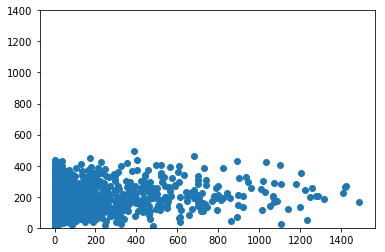

In [46]:
plt.scatter(y_test, predicted_vals_2)
plt.ylim(0,1400)

In [47]:
### GridSearch on data set 2
parameters = {"n_estimators": [10, 20, 50, 100, 200], "max_features": [.10, .30, .50, .90], "max_depth": [5, 10, 15, 20], "min_samples_leaf": [3, 5, 7, 10, 15]}
rf = RandomForestRegressor()
grid_2 = GridSearchCV(rf, parameters)

In [48]:
grid_2.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100, 200], 'max_features': [0.1, 0.3, 0.5, 0.9], 'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [3, 5, 7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [49]:
grid_2.best_score_

0.062241172353162989

In [50]:
grid_2.best_params_

{'max_depth': 15,
 'max_features': 0.3,
 'min_samples_leaf': 7,
 'n_estimators': 100}

In [119]:
rfr_best_params_2 = RandomForestRegressor(max_depth=15, max_features=0.3, min_samples_leaf=7, n_estimators=100)
rfr_best_params_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=0.3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [120]:
rfr_bp2_predictions = rfr_best_params_2.predict(X_test)

In [121]:
rfr_best_params_2.score(X_test, y_test)

0.059566023134615897

In [122]:
mean_absolute_error(y_test, rfr_bp2_predictions)

166.64589214845691

In [123]:
explained_variance_score(y_test, rfr_bp2_predictions)

0.060271251003626958

In [124]:
mean_squared_error(y_test, rfr_bp2_predictions)

58174.819628879632

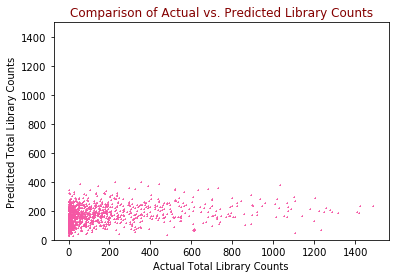

In [85]:
plt.scatter(y_test, rfr_bp2_predictions, marker="+", s=1, facecolor='#F557A4')
plt.ylim(1,1500)
plt.xlabel("Actual Total Library Counts")
plt.ylabel("Predicted Total Library Counts")
plt.title("Comparison of Actual vs. Predicted Library Counts", color="#840000")
plt.savefig("images/actual_vs_predicted_libcount_test.png", dpi=150)

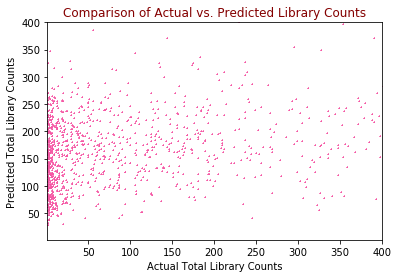

In [86]:
plt.scatter(y_test, rfr_bp2_predictions, marker="+", s=1, facecolor='#F557A4')
plt.ylim(1,400)
plt.xlim(1,400)
plt.xlabel("Actual Total Library Counts")
plt.ylabel("Predicted Total Library Counts")
plt.title("Comparison of Actual vs. Predicted Library Counts", color="#840000")
plt.savefig("images/actual_vs_predicted_libcount_detail_test.png", dpi=150)

In [87]:
features = X_train.columns

In [88]:
feature_imp_df = pd.DataFrame([features, rfr_best_params_2.feature_importances_]).transpose()
feature_imp_df.sort_values(by=1, ascending=False).head(20)

,0,1
0,age_in_2017,0.175673
4,title_length,0.115775
759,Tattoo,0.0768238
808,The,0.0692953
3,number_of_words,0.0472531
1,sentiment_polarity,0.0424254
2,sentiment_subjectivity,0.037646
56,American,0.0358619
210,Culture,0.0329912
786,Tattoos,0.0199434


### fit the model to the entire dataset

In [126]:
rfr_final = RandomForestRegressor(max_depth=15, max_features=0.3, min_samples_leaf=7, n_estimators=100)
rfr_final.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features=0.3, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=7, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [106]:
features_final = X.columns

In [107]:
feature_imp_final = pd.DataFrame([features_final, rfr_final.feature_importances_]).transpose()
feature_imp_final.sort_values(by=1, ascending=False).head(20)

,0,1
0,age_in_2017,0.136255
4,title_length,0.0987451
759,Tattoo,0.0590983
808,The,0.0535636
3,number_of_words,0.0444042
56,American,0.0307775
2,sentiment_subjectivity,0.0292889
1,sentiment_polarity,0.0283698
210,Culture,0.0180461
786,Tattoos,0.0168652


In [108]:
#add scoring on whole model
predictions = rfr_final.predict(X)

In [109]:
rfr_final.score(X, y)

0.2654275198736854

In [110]:
explained_variance_score(y, predictions)

0.26543706773921738

In [111]:
mean_absolute_error(y, predictions)

145.84612469661926

In [112]:
mean_squared_error(y, predictions)

47208.910351087754

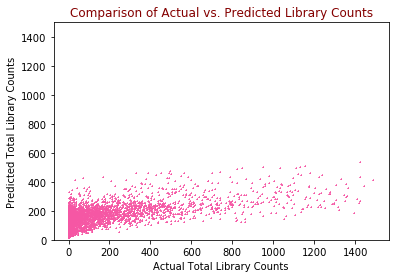

In [97]:
plt.scatter(y, predictions, marker="+", s=1, facecolor='#F557A4')
plt.ylim(1,1500)
plt.xlabel("Actual Total Library Counts")
plt.ylabel("Predicted Total Library Counts")
plt.title("Comparison of Actual vs. Predicted Library Counts", color="#840000")
plt.savefig("images/actual_vs_predicted_libcount.png", dpi=150)

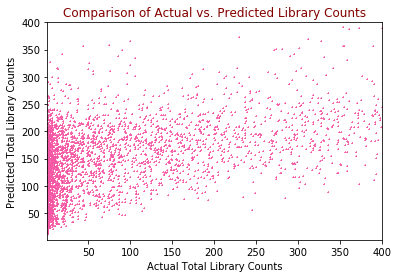

In [98]:
plt.scatter(y, predictions, marker="+", s=1, facecolor='#F557A4')
plt.ylim(1,400)
plt.xlim(1,400)
plt.xlabel("Actual Total Library Counts")
plt.ylabel("Predicted Total Library Counts")
plt.title("Comparison of Actual vs. Predicted Library Counts", color="#840000")
plt.savefig("images/actual_vs_predicted_libcount_detail.png", dpi=150)

In [71]:
rfr_final.predict(pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/test_data/test titles/X2_Ancient_Inkc_the_historical_mystery_of_tattoos.csv"))

array([ 169.09884698])

In [72]:
rfr_final.predict(pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/test_data/test titles/X2_Ancient_Inkc_the_historical_mystery_of_tattoos_5.csv"))

array([ 166.45283598])

In [73]:
rfr_final.predict(pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/test_data/test titles/X2_Ancient_Inkc_the_historical_mystery_of_tattoos_10.csv"))

array([ 157.31614497])

In [74]:
rfr_final.predict(pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/test_data/test titles/X2_I_love_cats.csv"))

array([ 96.57715217])

In [128]:
rfr_final.predict(pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/test_data/test titles/X2_Tattoos_Rock.csv"))

array([ 80.16689242])

In [76]:
rfr_final.predict(pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/test_data/test titles/X2_Tattoos_Rock_2.csv"))

array([ 74.35782841])

In [77]:
rfr_final.predict(pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/test_data/test titles/X2_Tattoos_Rock_10.csv"))

array([ 81.84010118])

new predictions with pipeline here

In [127]:
rfr_final.predict(pd.read_csv("/Users/annafriedman/GA/GACapstoneProject/test_data/test titles/X3_Marking_Identityc_Maori_Tattoos_and_Cultural_History.csv"))

array([ 207.77417811])